# Setup and processing

In [2]:
# Python packages
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [3]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)
seed = 10
np.random.seed(seed)

In [4]:
import warnings
warnings.filterwarnings('ignore')

# from https://github.com/scverse/scanpy/issues/2333#issuecomment-1563790561
def split_umap(adata, split_by, ncol=2, nrow=None, **kwargs):
    categories = adata.obs[split_by].cat.categories
    if nrow is None:
        nrow = int(np.ceil(len(categories) / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow))
    axs = axs.flatten()
    for i, cat in enumerate(categories):
        ax = axs[i]
        sc.pl.umap(adata[adata.obs[split_by] == cat], ax=ax, show=False, title=cat, **kwargs)
    plt.tight_layout()

In [8]:
input_file = "/data/cephfs-1/work/groups/cubi/users/cemo10_c/scRNA/scRNA_preprocessing_pipeline/results/preprocessing/subset.h5ad"
layer_to_use = "log1p_norm_of_soupX_counts"
scale_data_before_pca = True
genes_for_pca = "highly_variable_per_sample" # "all" or "globally_highly_variable" or "highly_variable_per_sample"
cc_method = "None" # None or "regress_out" or "cc_genes_out" or "cc_difference_regressed_out"
pca_n_components = 100
umap_n_neighbors = 50
output_file = "None"

In [6]:
adata = sc.read_h5ad(input_file, backed = False)
adata

AnnData object with n_obs × n_vars = 34198 × 11341
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score_based_on_soupX_counts', 'scDblFinder_class_based_on_soupX_counts', 'size_factors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_1', 'leiden_2', 'CMS1_score', 'CMS2_score', 'CMS3_score', 'CMS4_score', 'CMS', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine', 'treatment', 'week', 'sample'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'analytic_pearson_residuals_of_counts', 'analytic_pearson_residuals_of_soupX_counts', 'counts', 'log1p_norm_of_counts', 'log1p_norm_of_soupX_counts', 'scran_

In [9]:
adata.X = adata.layers[layer_to_use].copy()

In [11]:
cell_cycle_genes = [x.strip() for x in open('/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/resources/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

sc.pp.scale(adata)
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata.obs["cell_cycle_diff"] = adata.obs["S_score"] - adata.obs["G2M_score"]

if not scale_data_before_pca:
    adata.X = adata.layers[layer_to_use].copy()
    print("Not scaling data before PCA")
else:
    print("Scaling data before PCA")

Scaling data before PCA


In [ ]:
if "globally_highly_variable":
    sc.pp.highly_variable_genes(adata)
    print('Using globally highly variable genes')
elif genes_for_pca == "highly_variable_per_sample":
    sc.pp.highly_variable_genes(adata, batch_key = "sample")
    print('Using highly variable genes per sample. This simple process avoids the selection of batch-specific genes and acts as a lightweight batch correction method.')

if cc_method == "cc_genes_out":
    adata.var.loc[cell_cycle_genes, "highly_variable"] = False
    print('Removing cell cycle genes from highly variable genes')
elif cc_method == "regress_out":
    sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
    print('Regressing out cell cycle scores')
elif cc_method == "cc_difference_regressed_out":
    sc.pp.regress_out(adata, ['cell_cycle_diff'])
    print('Regressing out cell cycle difference score')
elif cc_method == "None":
    print('Not removing cell cycle effects')

Using globally highly variable genes
Not regressing out cell cycle scores


In [14]:
sc.tl.pca(adata, n_comps = pca_n_components, use_highly_variable = False if genes_for_pca == "all" else True)
sc.pp.neighbors(adata, n_pcs = umap_n_neighbors)
sc.tl.umap(adata, n_components=2)

In [16]:
# set plotting colors
if len(adata.obs['sample'].cat.categories) == 15:
    adata.uns["sample_colors"] = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 'green', 
                              '#8c564b', '#e377c2', 'yellow', '#bcbd22', 'red', 
                              '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 'lightgreen']

adata.uns["phase_colors"] = ['#f8766d', '#00ba38', '#619cff']
adata.uns["week_colors"] = ['dodgerblue', 'darkviolet', 'red', 'yellow', 'limegreen']
adata.uns['treatment_colors'] = ['#00C094', '#FB61D7', 'blue']

# PCA plots

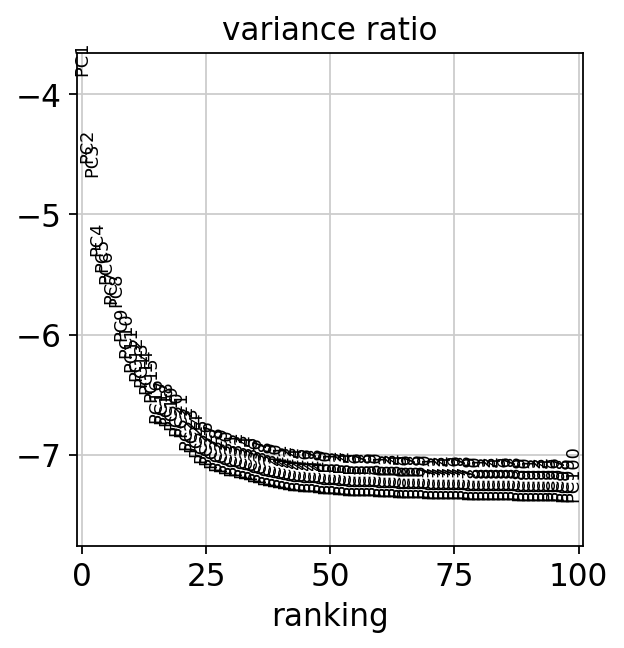

In [17]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 100)

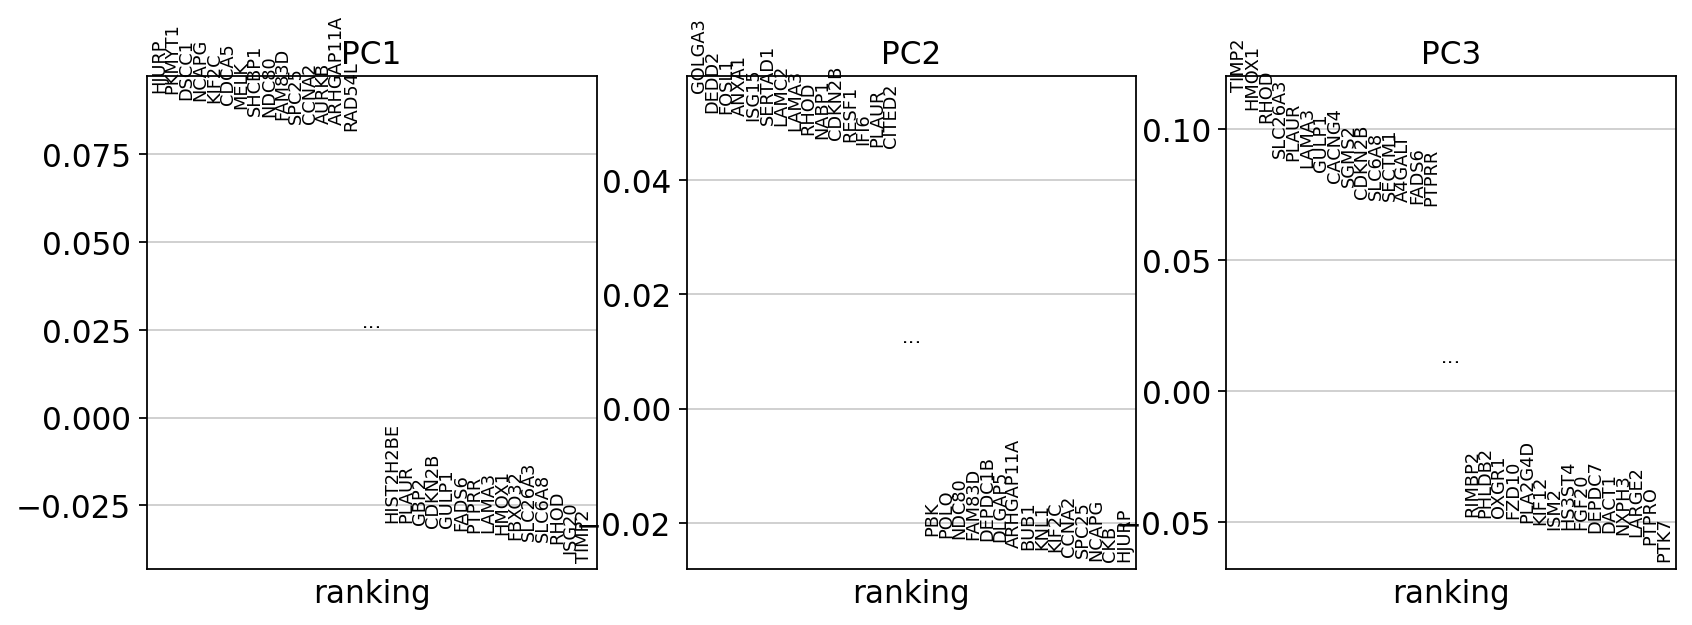

In [18]:
sc.pl.pca_loadings(adata)

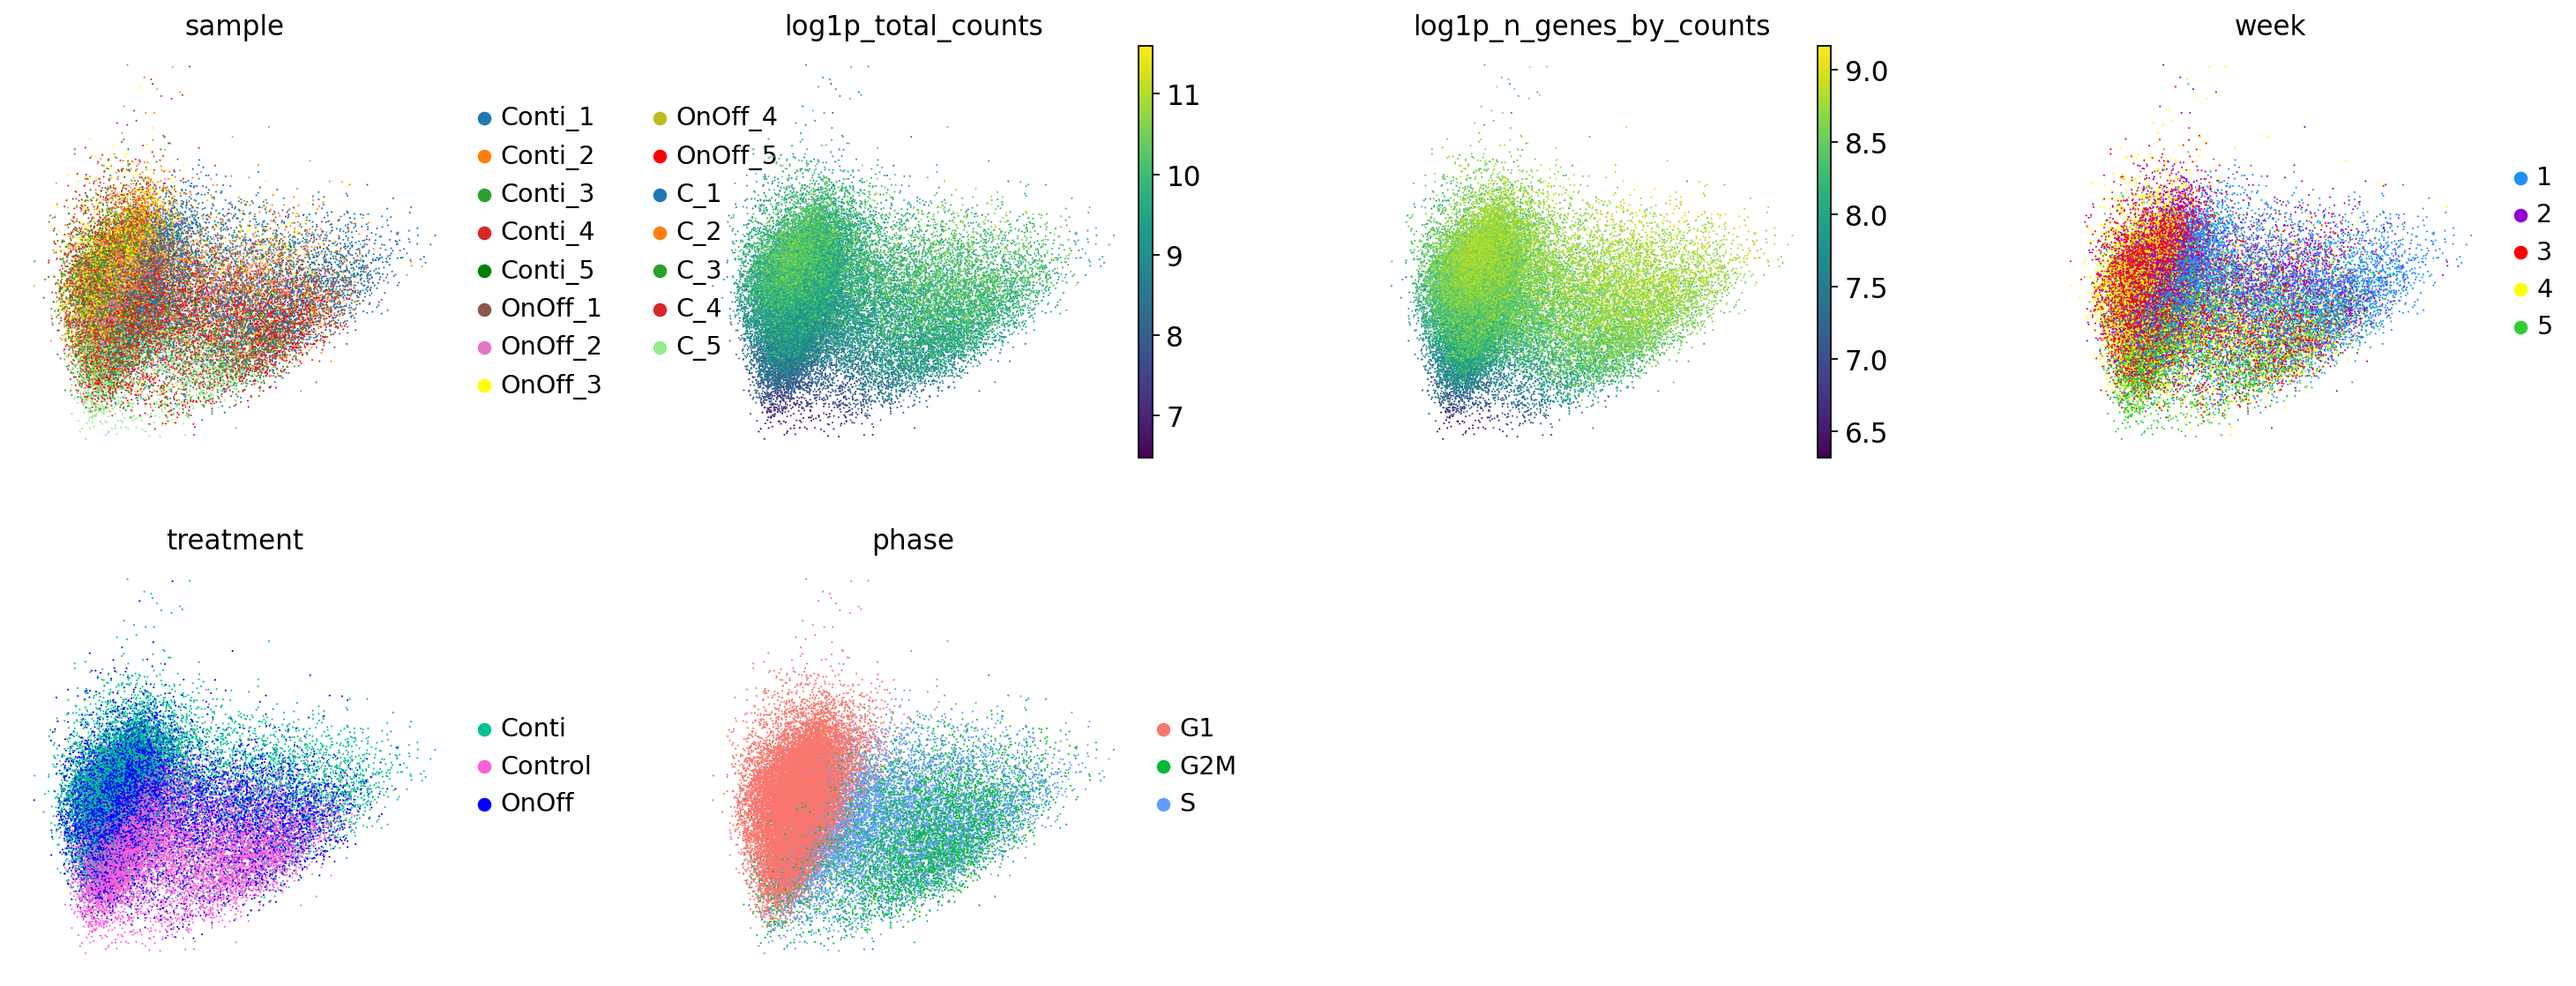

In [19]:
sc.pl.pca(adata, projection = "2d", 
          color = ['sample', 'log1p_total_counts', 'log1p_n_genes_by_counts', 'week', 'treatment', 'phase'],
          wspace = 0.4)

# UMAP plots

## All samples

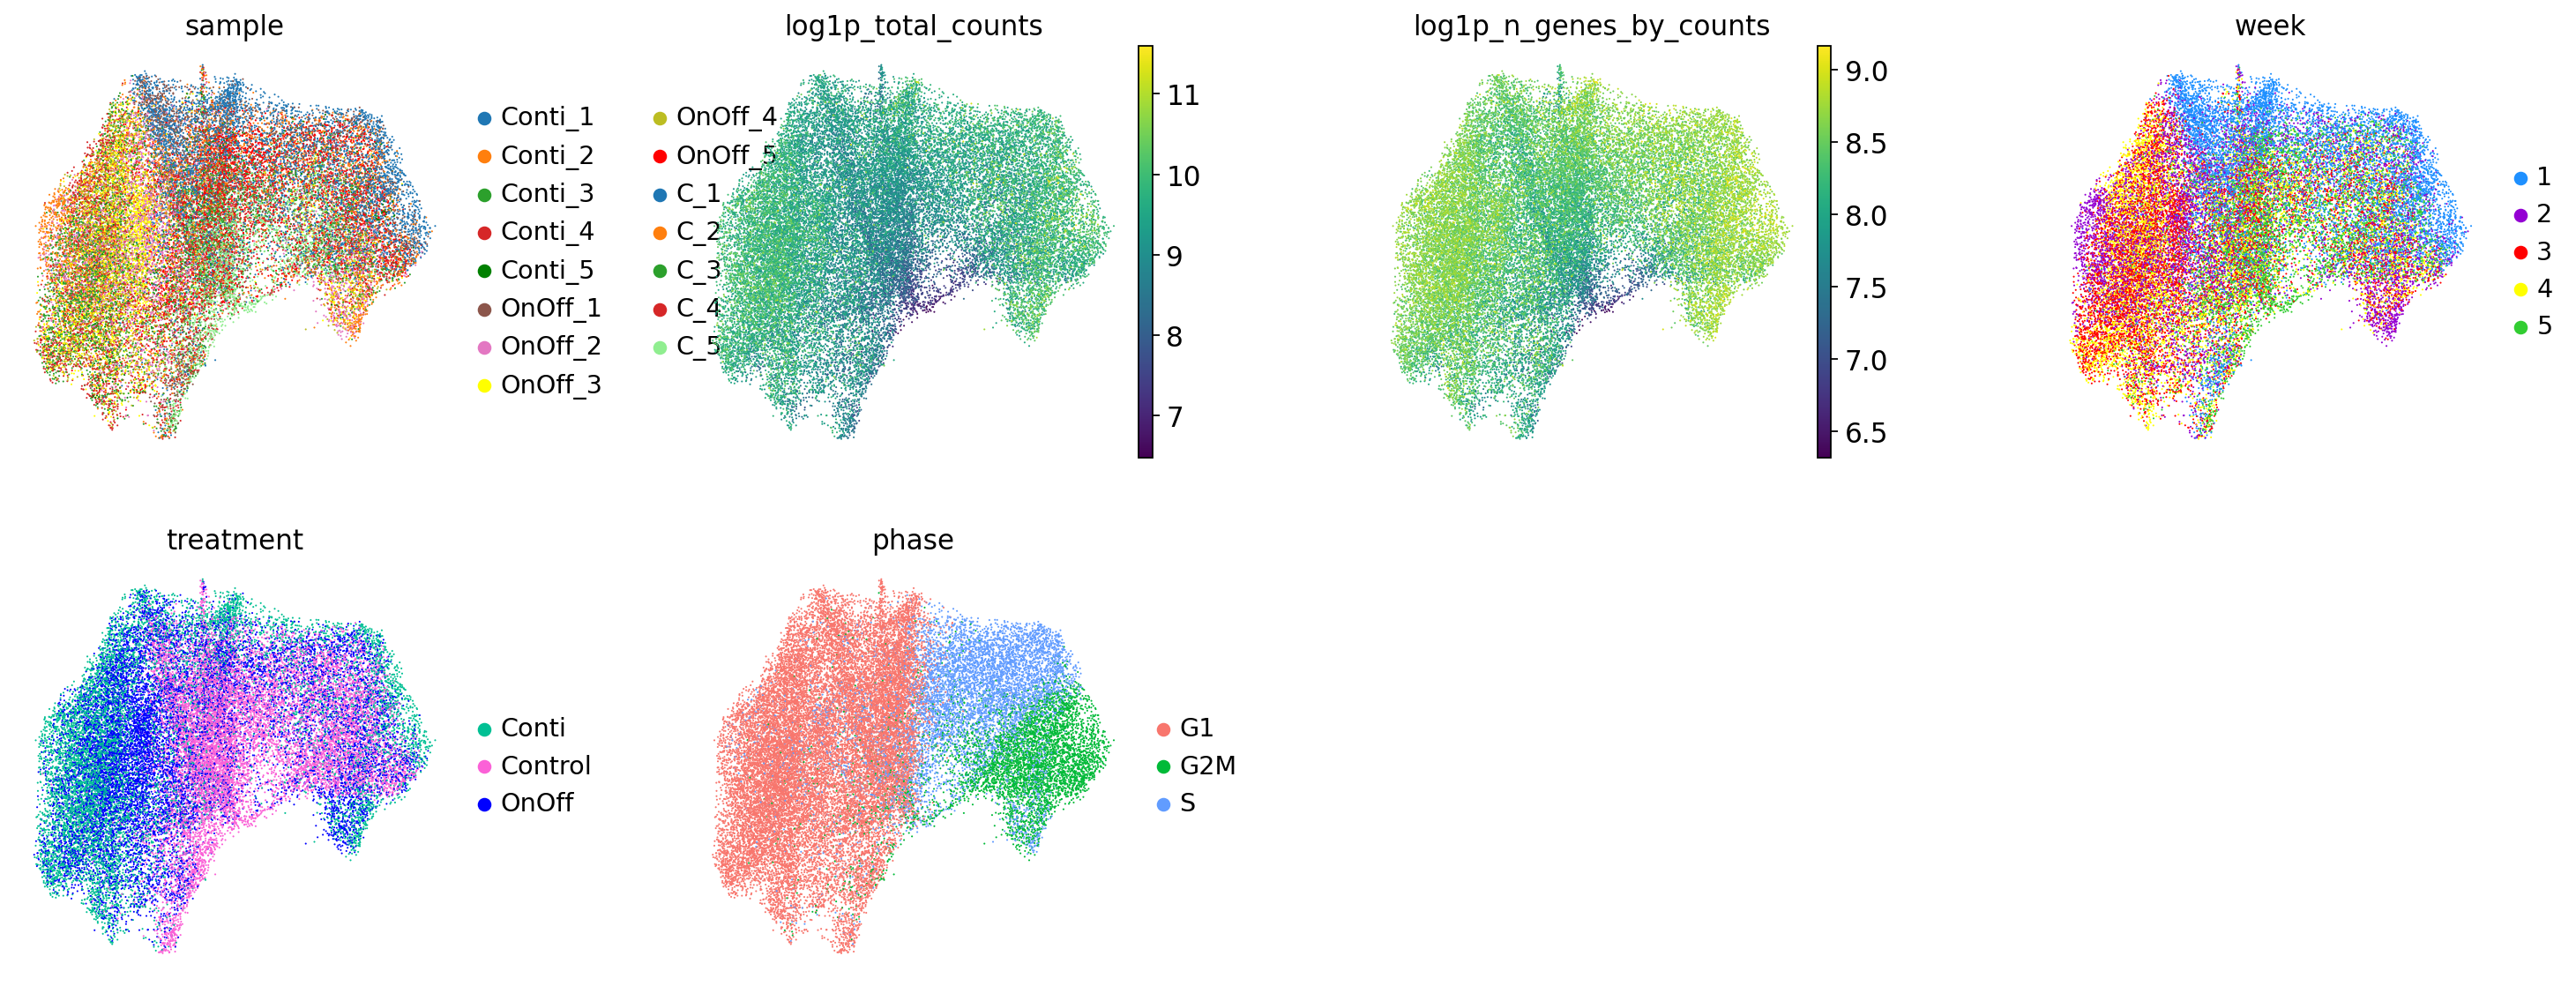

In [20]:
sc.pl.umap(adata,
          color = ['sample', 'log1p_total_counts', 'log1p_n_genes_by_counts', 'week', 'treatment', 'phase'],
          wspace = 0.4)

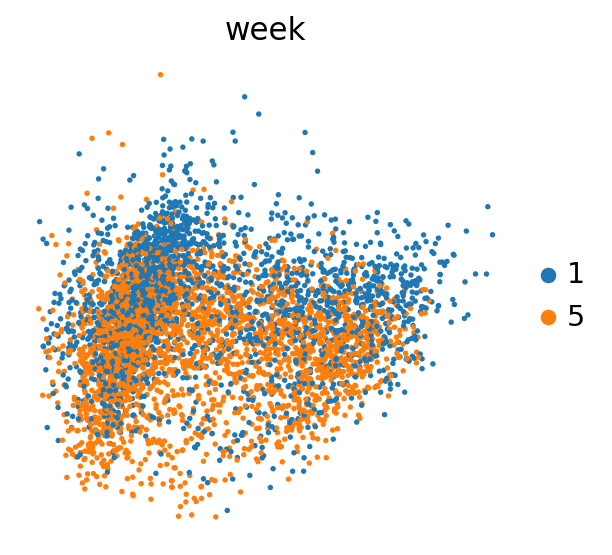

In [21]:
# subset only treatment OnOff weeks 1 and 5
adata_sub = adata[adata.obs["treatment"] == "OnOff"]
adata_sub = adata_sub[adata_sub.obs["week"].isin(["1", "5"])]

# treatment OnOff week 1 vs week 5
sc.pl.pca(adata_sub, color=["week"], palette = ["#1f77b4", "#ff7f0e"])

## Only week 1 of every treatment

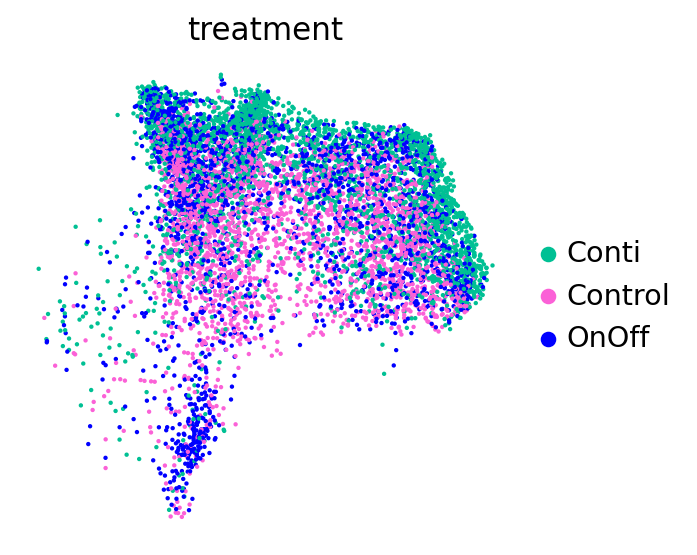

In [22]:
sc.pl.umap(adata[adata.obs["week"] == "1"], color=["treatment"])

## All treatments separately

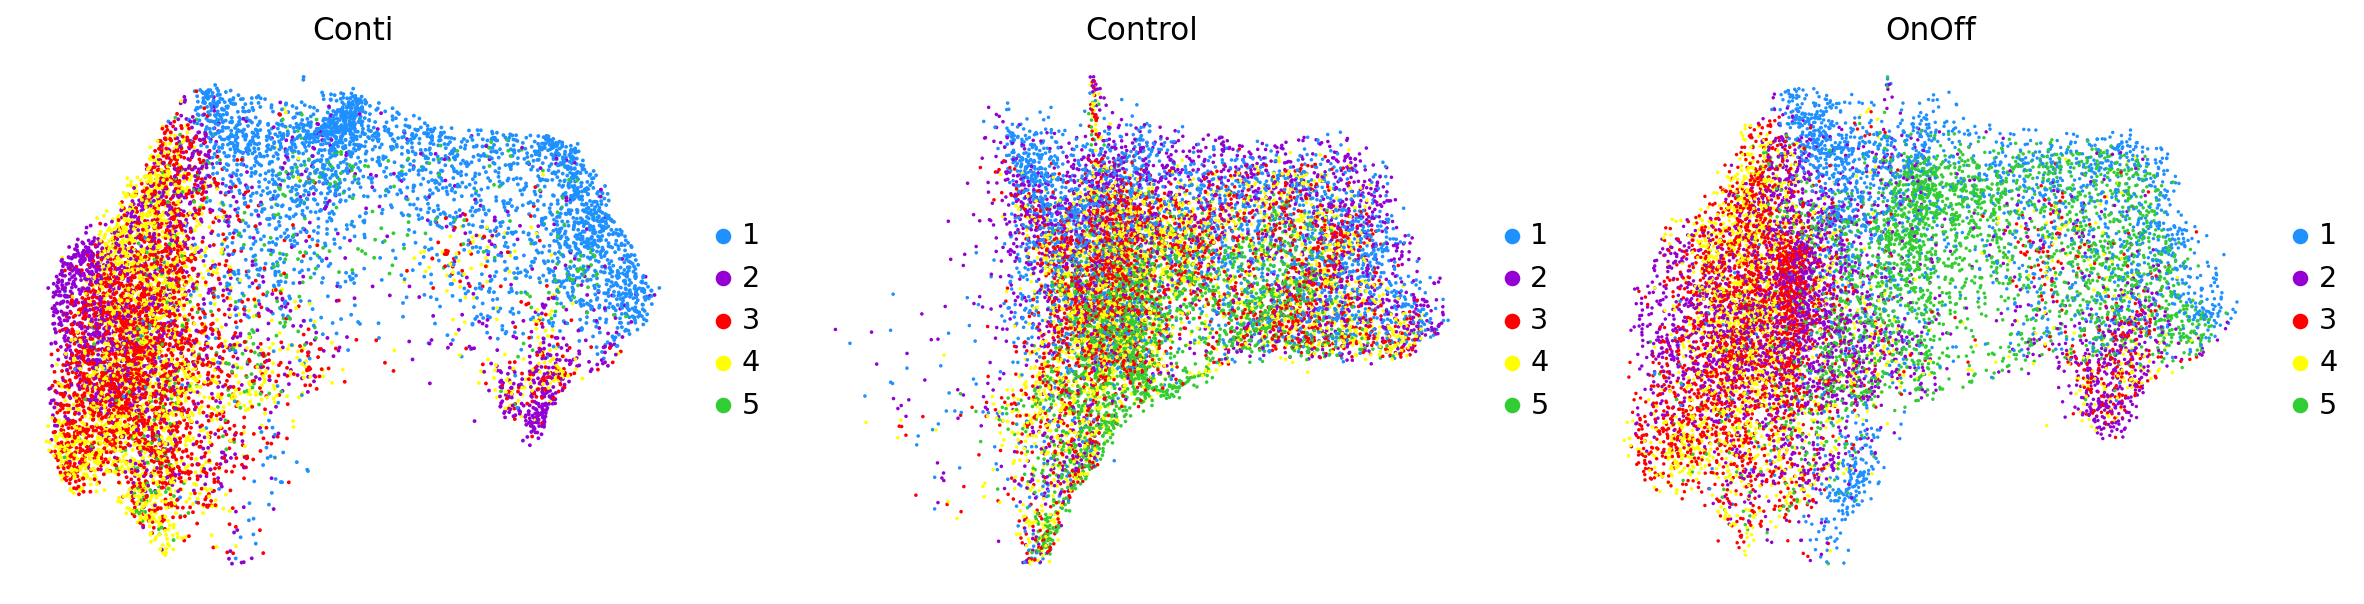

In [23]:
split_umap(adata, color = ['week'], split_by='treatment', ncol = 3)

## Only week 1 and 5 of the OnOff treatment

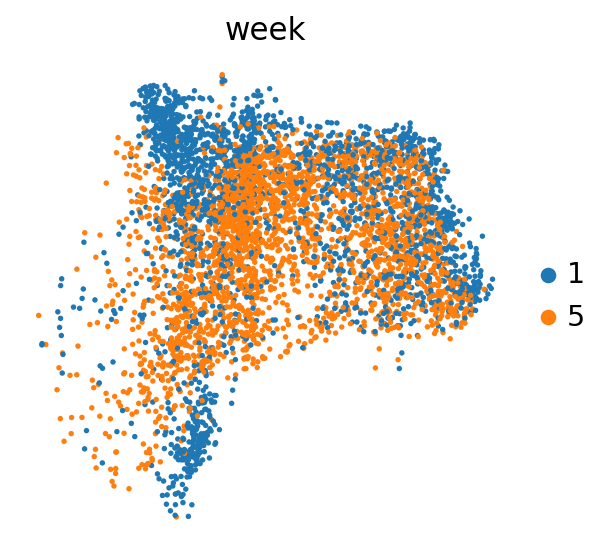

In [24]:
sc.pl.umap(adata_sub, color=["week"], palette = ["#1f77b4", "#ff7f0e"])

## All samples separately

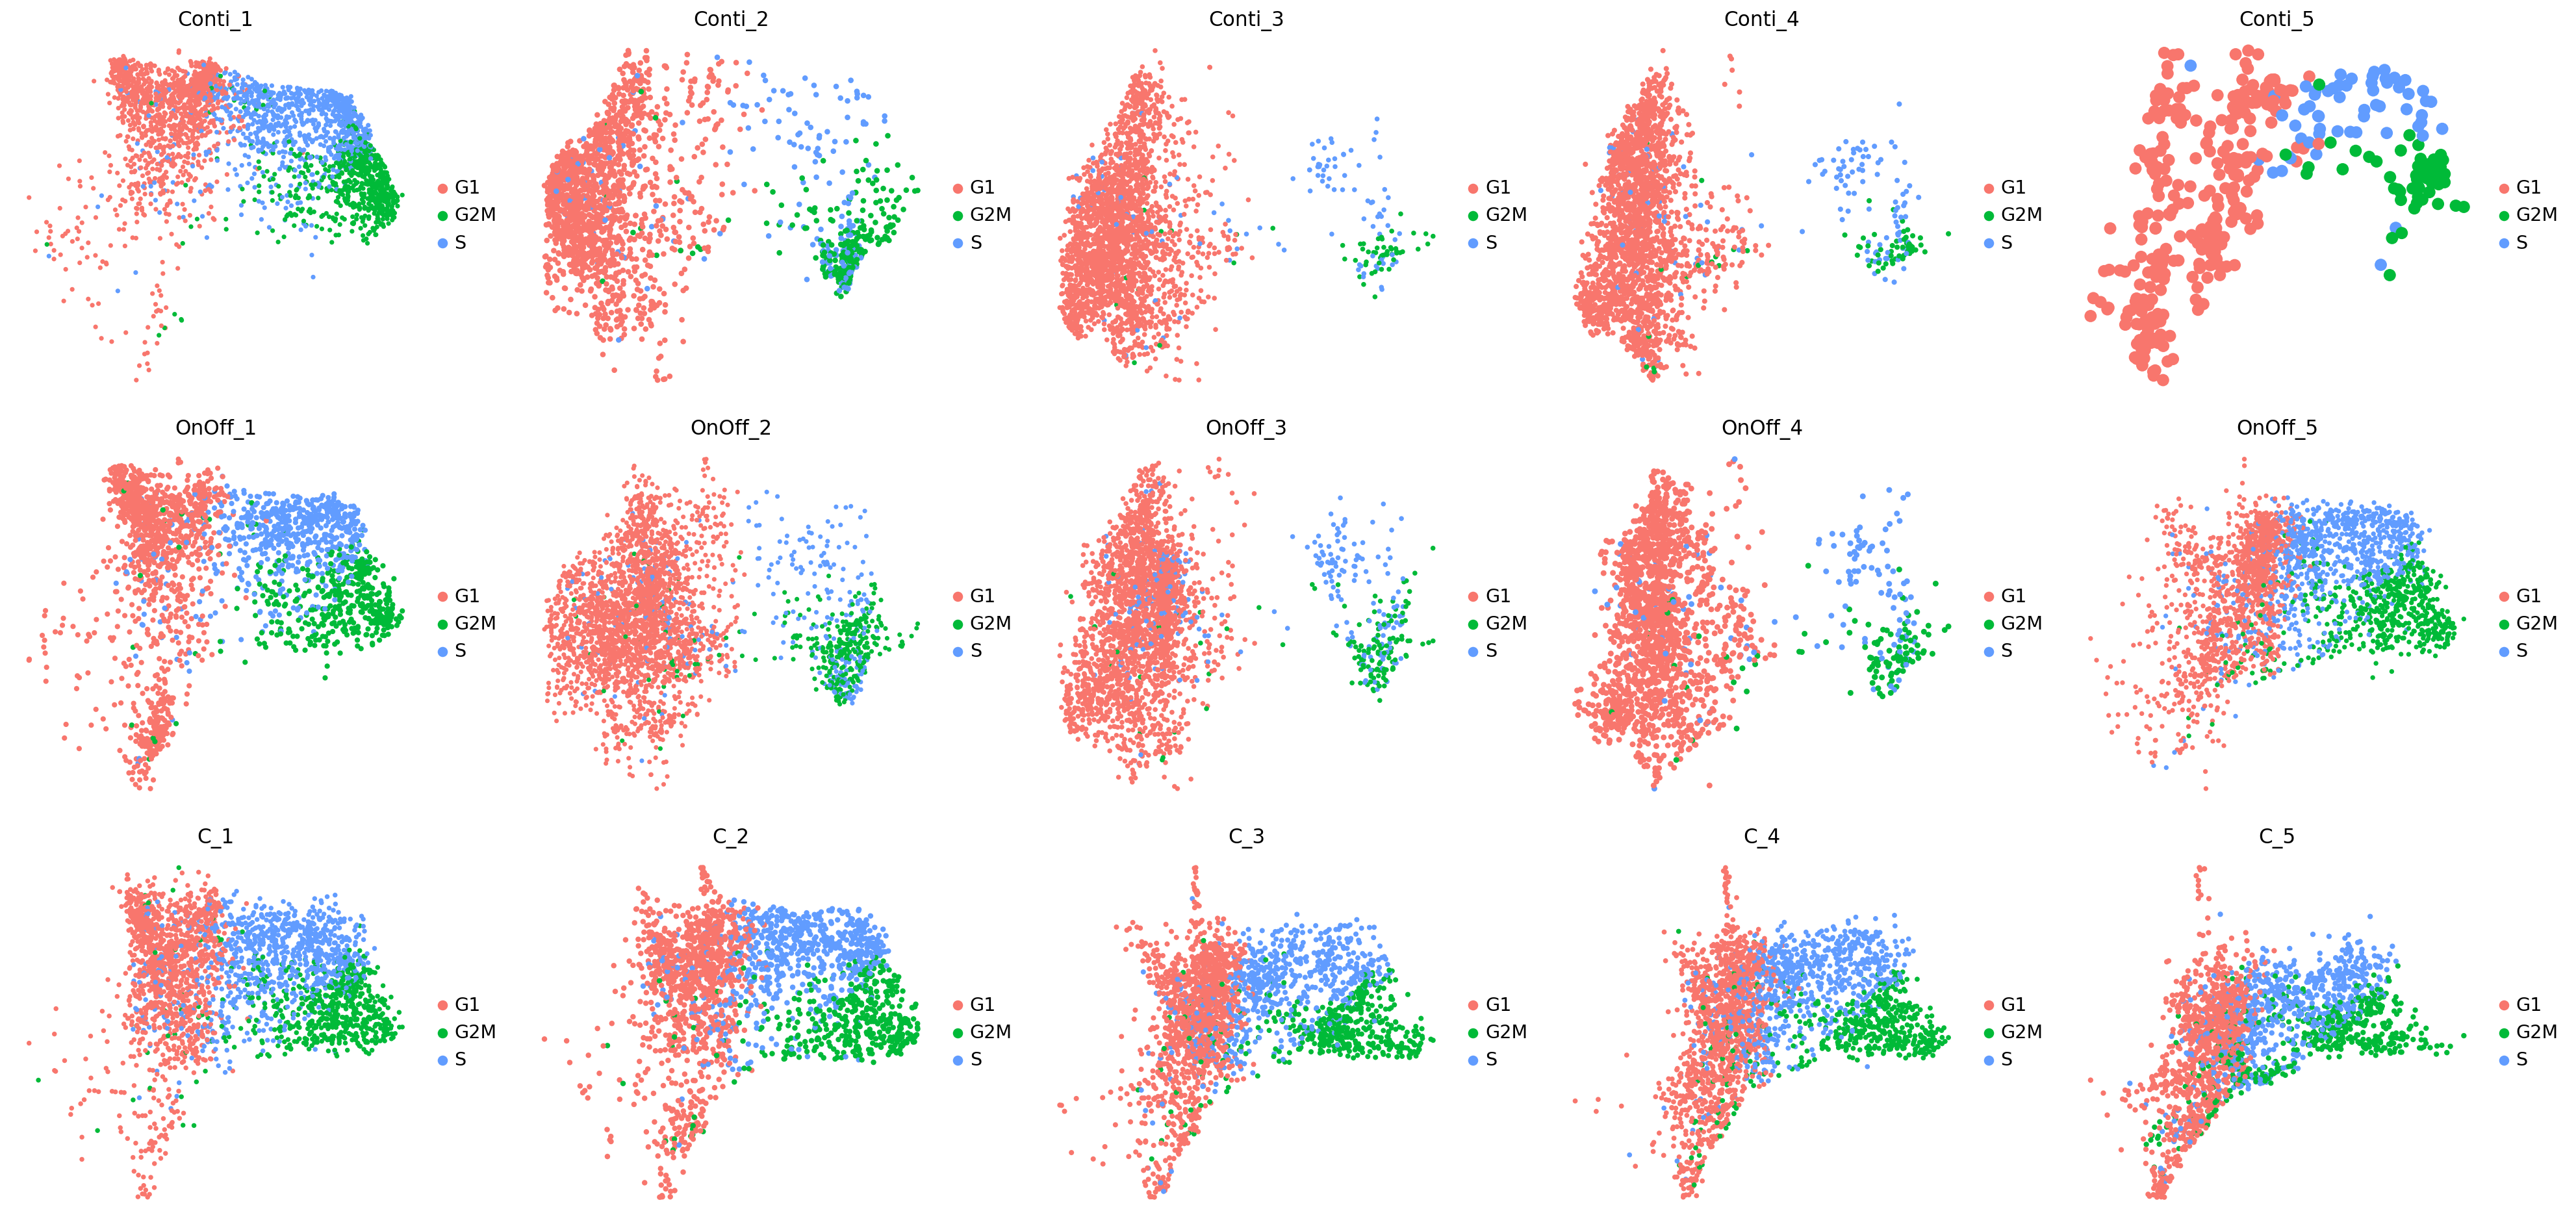

In [25]:
split_umap(adata, color = ['phase'], split_by='sample', ncol = 5)

## Only week 5 of control and OnOff treatment

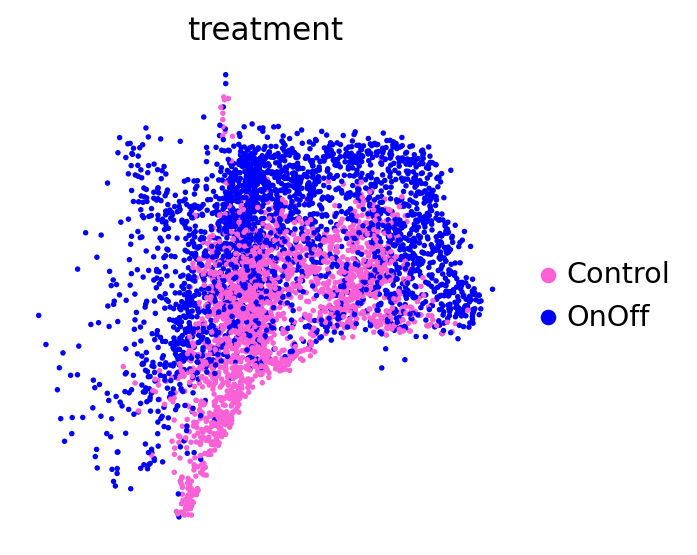

In [27]:
adata_sub2 = adata[adata.obs["week"] == "5"]
adata_sub2 = adata_sub2[adata_sub2.obs["treatment"].isin(["Control", "OnOff"])]
sc.pl.umap(adata_sub2, color = ['treatment'])

In [ ]:
# adata.write(output_file)